In [4]:
from datetime import datetime
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
#from netCDF4 import num2date
import numpy as np
import pandas as pd
import geopandas as gpd
import shapely
#from siphon.catalog import TDSCatalog
from urllib.error import HTTPError
%matplotlib inline

In [2]:
def baggervak_to_current(path_shp, crs_string):
    """
    function to get current valid baggervakken
    also sets appropriate coordinates system
    """

    gdf = gpd.read_file(path_shp)
    gdf.crs = rd_string

    # only get currently valid shapes
    # get list of duplicates (both the first and last [and middles if available])
    duplicates_all = gdf[gdf['OBJECTCODE'].duplicated(keep=False)]
    for obj in duplicates_all['OBJECTCODE'].unique():
        duplicates_single = duplicates_all.loc[duplicates_all['OBJECTCODE'] == obj]
        rows2drop = duplicates_single.loc[duplicates_single['END']
                                          != duplicates_single['END'].max()]
        gdf.drop(rows2drop.index.tolist(), axis=0, inplace=True)
    return gdf

In [3]:
def discrete_cmap(N, base_cmap=None):
    """Create an N-bin discrete colormap from the specified input map"""

    # Note that if base_cmap is a string or None, you can simply do
    #    return plt.cm.get_cmap(base_cmap, N)
    # The following works for string, None, or a colormap instance:

    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    return base.from_list(cmap_name, color_list, N)

In [4]:
def plotwind(X, Y, U, V, T, WD, print_plot=True, print_save=False):
    # Create a new figure
    fig = plt.figure(figsize=(15, 12))

    # Add the map and set the extent
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.set_extent([4.59, 7.28, 52.86, 53.66])

    # Add state boundaries to plot
    states_provinces = cfeature.NaturalEarthFeature(
        category='physical',
        name='coastline',
        scale='10m',
        facecolor='lightgray')
    ax.add_feature(states_provinces, edgecolor='black', linewidth=2)

    N = 4
    im = plt.imshow(WD, extent=(left, right, bottom, top), transform=ccrs.PlateCarree(
    ), zorder=2, alpha=0.5, vmin=1, vmax=3, cmap=discrete_cmap(N, 'jet'))
    cb = plt.colorbar(im, orientation='horizontal', ticks=range(N))
    cb.set_ticklabels(['NE', 'SE', 'SW', 'NW'])
    cb.set_label('Wind direction', size=20)
    cb.ax.tick_params(labelsize=20)
    cb.ax.xaxis.set_label_position('top')
    plt.clim(-0.5, N - 0.5)

    qui = ax.quiver(X, Y, U, V, transform=ccrs.PlateCarree(), zorder=2)
    # Make a title with the time value
    ax.set_title('Windfield forecast for {0:%d %B %Y %H:%MZ}'.format(T),
                 fontsize=20, family='monospace')
    #plt.quiverkey(qui, 0.9, 1.05, 1, '1 m/s', labelpos='S',fontproperties={'weight': 'bold'})

    if print_plot == True:
        plt.show()
        
    if print_save == True:
        plt.tight_layout()
        plt.savefig(r'D:\Projects\Pr\3317.20\GFS_forecast\fc_{}.png'.format(
            int(T.timestamp())))   
        plt.close(fig)
        fig.clear()

In [5]:
def get_wind_forecast_GFS(catalog='best'):
    
    base_url = 'http://thredds.ucar.edu/thredds/catalog/grib/NCEP/GFS/Global_0p25deg/'
    
    if catalog == 'best':
        time_name_index_location = 1
        best_gfs = TDSCatalog('{}{}'.format(base_url, 'catalog.xml?dataset=grib/NCEP/GFS/Global_0p25deg/Best'))
    if catalog == 'latest':
        time_name_index_location = 0
        best_gfs = TDSCatalog('{}{}'.format(base_url, 'latest.xml'))
    
    #print(list(best_gfs.datasets))    

    best_ds = best_gfs.datasets[0]
    ncss = best_ds.subset()

    # setup query for waddensea region collecting u- and v-components
    query = ncss.query()
    query.all_times()
    query.lonlat_box(north=53.66, south=52.86, east=7.28, west=4.59)
    query.accept('netcdf4')
    query.variables('u-component_of_wind_height_above_ground','v-component_of_wind_height_above_ground')
    query.vertical_level(10)

    data = ncss.get_data(query)
    #print(list(data.variables))

    # get variables in the returend dataset
    lat_var = data.variables['lat']
    lon_var = data.variables['lon']
    u_var = data.variables['u-component_of_wind_height_above_ground']
    v_var = data.variables['v-component_of_wind_height_above_ground']
    time_name = u_var.coordinates.split()[time_name_index_location]
    time_var = data.variables[time_name]

    # flat 1 dimension
    u_vals = u_var[:].squeeze()
    v_vals = v_var[:].squeeze()
    lat_vals = lat_var[:].squeeze()
    lon_vals = lon_var[:].squeeze()
    time_vals = time_var[:].squeeze()

    # Convert the number of hours since the reference time to an actual date
    time_val = num2date(time_vals, time_var.units)

    return lon_vals, lat_vals, u_vals, v_vals, time_val

In [6]:
def GFS_to_wind_direction_velocity(lon_vals, lat_vals, u_vals, v_vals, time_val):
    # create meshgrid for plotting purposes
    X, Y = np.meshgrid(lon_vals, lat_vals)
    T_list = []
    WD_mean_list = []
    WS_mean_list = []

    for idx, T in enumerate(time_val):
        #print(idx, T)
        U, V = u_vals[idx], v_vals[idx]
        WS = np.sqrt(U**2 + V**2)
        WD = (np.arctan2(U, V)) * (180 / np.pi) + 180.0

        if (WD.all() is np.ma.masked):
            next
        else:
            # mask land and northsea
            mask = [[True,  True,  True,  True,  True,  True,  True,  True, False, False, False,  True],
                    [True,  True, False, False, False, False, False, False, False, False, False,  True], 
                    [False, False, False, False, False, False,  True,  True,  True, True, False, False], 
                    [False, False, False, False,  True,  True,  True,  True,  True, True,  True,  True], 
                    [False, False, False,  True,  True,  True,  True,  True,  True, True,  True,  True]
                   ]  
            WD = np.ma.MaskedArray(data=WD.data, mask=mask)
            WS = np.ma.MaskedArray(data=WS.data, mask=mask)

            # get mean of masked wind direction and velocity
            WD_mean_deg = np.ma.mean(WD)
            WS_mean = np.ma.mean(WS)

            # reclassification of array
            WD[np.ma.where(WD < 90)] = 0
            WD[np.ma.where((90 < WD) & (WD < 180))] = 1
            WD[np.ma.where((180 < WD) & (WD < 270))] = 2
            WD[np.ma.where((270 < WD) & (WD < 360))] = 3

            #print(T, WD_mean_deg)
            # mask arrays
            U = np.ma.MaskedArray(data=U.data, mask=mask)
            V = np.ma.MaskedArray(data=V.data, mask=mask)

            #plotwind(X, Y, U, V, T, WD, print_plot=False, print_save=False)

            # append arrea mean (single value) to list
            T_list.append(T)
            WD_mean_list.append(WD_mean_deg)
            WS_mean_list.append(WS_mean)

    # create pandas dataframe using wind direction velocity
    df_T_W = pd.DataFrame({'wind_direction': WD_mean_list, 'wind_velocity': WS_mean_list}, index=T_list)

    # hour to day average
    df_W_day = df_T_W.groupby(df_T_W.index.date).mean()

    # classify direction into NE (0), SE (1), SW (2) and NW (3)
    # wind is the direction where it comes from
    # eg. 0 means the wind comes from direction North-East
    WD_day_deg = np.array(df_W_day['wind_direction'].tolist())

    # reclassification of wind direction array
    WD_day_deg[np.ma.where(WD_day_deg < 90)] = 0
    WD_day_deg[np.ma.where((90 < WD_day_deg) & (WD_day_deg < 180))] = 1
    WD_day_deg[np.ma.where((180 < WD_day_deg) & (WD_day_deg < 270))] = 2
    WD_day_deg[np.ma.where((270 < WD_day_deg) & (WD_day_deg < 360))] = 3

    # set classified wind direction in dataframe
    df_W_day.loc[:,'wind_direction'] = WD_day_deg.astype(int)    
    
    return df_W_day

In [7]:
rd_string = ("+proj=sterea +lat_0=52.15616055555555 +lon_0=5.38763888888889 "
             "+k=0.999908 +x_0=155000 +y_0=463000 +ellps=bessel +units=m " 
             "+towgs84=565.2369,50.0087,465.658,-0.406857330322398,0.350732676542563,-1.8703473836068,4.0812 "
             "+no_defs +no_defs")

In [8]:
# path to shapefile dredgefields
shp_in = r'D:\FEWSprojecten\OmsWaddenzee\trunk\fews\Config\MapLayerFiles\Baggervakken//Baggervakken.shp'

In [9]:
# parse the shapefile into geodataframe
gdf = baggervak_to_current(path_shp=shp_in, crs_string=rd_string)

In [10]:
try:
    lon_vals, lat_vals, u_vals, v_vals, time_val = get_wind_forecast_GFS(catalog='best')
except:
    print('seems there was an error at the *best* catalog, lets try the *latest* forecast')
    lon_vals, lat_vals, u_vals, v_vals, time_val = get_wind_forecast_GFS(catalog='latest')

c:\python35\lib\site-packages\ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in greater
c:\python35\lib\site-packages\ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in greater


In [11]:
df_wind = GFS_to_wind_direction_velocity(lon_vals, lat_vals, u_vals, v_vals, time_val)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000000000A2355F8>,
      dtype=object)

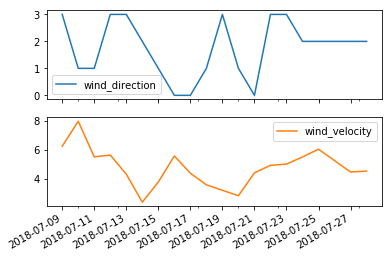

In [12]:
df_wind.plot(subplots=True)

In [13]:
df_wind['wind_velocity'].head()

2018-07-09    6.257633
2018-07-10    7.984992
2018-07-11    5.525599
2018-07-12    5.653172
2018-07-13    4.332416
Name: wind_velocity, dtype: float64

In [14]:
df_wind['wind_velocity'].to_csv(date_format='%Y%m%d')

'2018-07-09,6.257632608766909\n2018-07-10,7.984991780033817\n2018-07-11,5.525598702607331\n2018-07-12,5.653172104446976\n2018-07-13,4.332415933962222\n2018-07-14,2.4028981526692705\n2018-07-15,3.791456540425618\n2018-07-16,5.590766588846843\n2018-07-17,4.397900404753508\n2018-07-18,3.5981419704578546\n2018-07-19,3.2210548037574402\n2018-07-20,2.8501268581107815\n2018-07-21,4.4262439586498115\n2018-07-22,4.943645618580006\n2018-07-23,5.027640166106048\n2018-07-24,5.521965591995805\n2018-07-25,6.054178873697916\n2018-07-27,4.484934771502459\n2018-07-28,4.545209531430845\n'

In [24]:
datetime.today().strftime('%Y%m%d')

'20180712'

In [15]:
df_wind.index[-1].strftime('%Y%m%d')

'20180728'

In [59]:
csv_coeff = r'D:\Projects\Pr\3317.20\Wind_voorspelling\coefficients_baggervakken.csv'
df = pd.io.parsers.read_csv(csv_coeff, header = [0,1], tupleize_cols = True)
df.columns = [c for _, c in df.columns[:1]] + [c for c in df.columns[1:]]
df = df.set_index(df.columns[0])
df.columns = pd.MultiIndex.from_tuples(df.columns, names = ['wind_direction', 'coefficient'])

c:\python35\lib\site-packages\pandas\io\parsers.py:809: FutureWarning: The 'tupleize_cols' argument has been deprecated and will be removed in a future version. Column tuples will then always be converted to MultiIndex.


  self.options, self.engine = self._clean_options(options, engine)


In [60]:
df.head()

wind_direction Unnamed: 1_level_0 coeff_NE      coeff_SE      coeff_SW       \
coefficient            OBJECTNAAM        a    b        a    b        a    b   
OBJECTCODE                                                                    
1.7.2.3.2            Blauwe Slenk     -3.2  9.6      7.4 -5.0     -9.5 -4.0   
1.7.1.3.1         Visjagersgaatje      2.6  2.4      9.5  8.5      1.3  0.2   
1.7.3.1.1          Holwerd - VA25     -5.8  2.7     -3.6 -1.4     -4.3  7.9   
1.7.3.1.2.A             VA4 - VA6     -3.9 -3.1     -4.2  3.1     -1.2 -2.1   
1.7.3.1.3                 Reegeul     -4.8 -8.7     -1.5  2.4      9.5  6.7   

wind_direction coeff_NW       
coefficient           a    b  
OBJECTCODE                    
1.7.2.3.2           4.9  3.9  
1.7.1.3.1          -4.3 -3.3  
1.7.3.1.1          -8.5 -1.0  
1.7.3.1.2.A         1.6 -4.2  
1.7.3.1.3          -9.4  9.9

In [ ]:
gdf_merge = pd.merge(gdf,df, right_index=True, left_on='OBJECTCODE')

In [ ]:
for idx, item in df_wind.iterrows():
    
    if item['wind direction'] == 0:
        column = 'coeff_NE'
    if item['wind direction'] == 1:
        column = 'coeff_SE'
    if item['wind direction'] == 2:
        column = 'coeff_SW'
    if item['wind direction'] == 3:
        column = 'coeff_NW'
    

    coeff = pd.concat((gdf_merge[['OBJECTCODE', 'OBJECTNAAM', 'geometry']], gdf_merge[(
        column, 'a')], gdf_merge[(column, 'b')]), axis=1)
    coeff.loc[:,'wind_velocity'] = item['wind velocity']
    
    coeff.loc[:,'SDS'] = coeff[(column,'a')]*coeff['wind_velocity']+coeff[(column,'b')]
    print(coeff[['wind_velocity', 'SDS']].head(1))
    print(idx, column, '\n')
    #print(idx, column, item['wind velocity'])

In [ ]:
coeff